# Planar data classification with one hidden layer

Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- 单隐藏层的神经网络实现二分类
- 使用非线性激活函数，such as tanh 
- 计算交叉熵损失
- 实现前向传播和后向传播

## 1 - 第三方包 ##

Let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [2]:
X,Y = load_planar_dataset()

红色（y=0）,蓝色（y=1）

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

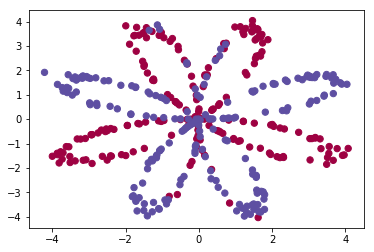

In [3]:
# 可视化数据
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
#c:颜色，s：size,cmap=plt.cm.Spectral:颜色图谱n

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

**Hint**: How do you get the shape of a numpy array? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
shape_X = X.shape
shape_Y = Y.shape
m = Y.size

print 'The shape of X is: ' + str(shape_X)
print 'The shape of Y is: ' + str(shape_Y)
print 'I have m = %d training examples!' % (m)

The shape of X is: (2L, 400L)
The shape of Y is: (1L, 400L)
I have m = 400 training examples!


## 3 - 简单逻辑回归

Before building a full neural network, lets first see how logistic regression performs on this problem. **You can use sklearn's built-in functions to do that.** Run the code below to train a logistic regression classifier on the dataset.

In [5]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T)

D:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [6]:
foo = [2, 18, 9, 22, 17, 24, 8, 12, 27]
print filter(lambda x: x % 3 == 0, foo)
print map(lambda x: x * 2 + 10, foo)
print reduce(lambda x, y: x + y, foo)

[18, 9, 24, 12, 27]
[14, 46, 28, 54, 44, 58, 26, 34, 64]
139


Accuracy of logistic regression: 47 % 


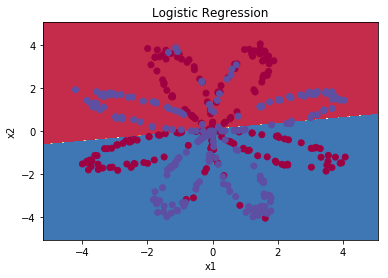

In [7]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

#准确率
LR_predictions = clf.predict(X.T)
# 准确率为相同个数/总数
Accuracy = float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100)
print 'Accuracy of logistic regression: %d ' % Accuracy + '% '

**解释**:数据集不是线性分离的，所以逻辑回归不能很好地表现。
希望一个神经网络会做得更好。
我们现在试试吧！

## 4 - 神经网络模型

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**下面是我们的模型**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**数学公式**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: 构建神经网络模型的方法:
    1. 定义神经网络的结构 ( # of input units,  # of hidden units, etc). 
    2. 初始化参数
    3. 循环:
        - Implement 前向传播
        - 计算损失函数
        - Implement 反向传播获得梯度
        - 更新参数 (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - 定义神经网络的结构 ####

**Exercise**: 三个参数:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [8]:
# 获取神经网络层数

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

**这里是测试**

In [9]:
X_assess, Y_assess = layer_sizes_test_case()   
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


### 4.2 - 初始化模型参数 ####

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
    - You will initialize the weights matrices with random values. （权重向量W）
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros.(偏置向量b) 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [10]:
np.random.seed(0)
np.random.rand(4)

array([ 0.5488135 ,  0.71518937,  0.60276338,  0.54488318])

In [11]:
np.random.seed(0)
np.random.rand(4)  

array([ 0.5488135 ,  0.71518937,  0.60276338,  0.54488318])

In [12]:
np.random.rand(4)  

array([ 0.4236548 ,  0.64589411,  0.43758721,  0.891773  ])

In [13]:
#初始化参数
def initialize_parameters(n_x,n_h,n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
    

**测试**

In [14]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[ 0.]]


### 4.3 - 循环 ####

**Question**: Implement `forward_propagation()`.
**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.


In [15]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # 从字典"parameters"中，获取参数
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #正向传播计算A2
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoid(Z2)
        
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache
    
    

In [16]:
a = np.array([[1,2],[3,4]])
print a
a + np.array([[5],[5]])  
# 相当于每列都加上了np.array([[5],[5]])  

[[1 2]
 [3 4]]


array([[6, 7],
       [8, 9]])

**测试**

In [17]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

(-0.00049975577774199022, -0.00049696335323177901, 0.00043818745095914653, 0.50010954685243103)


$A^{[2]}$ (in the Python variable "`A2`")中包含每一个样本的 $a^{[2](i)}$ , 下面可以计算cost function:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercise**: 实现`compute_cost()`函数，计算 cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss（交叉熵损失）. To help you, we give you how we would have implemented
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
#相乘然后相加
logprobs = np.multiply(np.log(A2),Y)  
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(you can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).


In [18]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    m = Y.shape[1]
    
    # 取参W1，W2
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # 计算cost函数
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = -np.sum(logprobs)/m 
    cost = np.squeeze(cost)     #删除维度为1的维度
    
    assert(isinstance(cost, float))
    
    return cost

**测试**

In [19]:
A2, Y_assess, parameters = compute_cost_test_case()
'''
m = Y_assess.shape[1]
W1 = parameters['W1']
W2 = parameters['W2']
Y = Y_assess

logprobs = np.multiply(np.log(A2),Y) +  np.multiply(np.log(1-A2),(1-Y))
cost = -1/m * np.sum(logprobs)
cost = np.squeeze(cost)     #删除维度为1的维度
'''
print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.692919893776


Using the cache computed during forward propagation, you can now implement backward propagation.

**Question**: Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, **if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$.** So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [20]:
# GRADED FUNCTION: backward_propagation
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache['A1']
    A2 = cache['A2']
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2= A2 - Y
    dW2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis=1, keepdims=True)/m
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [21]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()


grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[ 0.06589489]]


**Question: 实现更新规则**. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**（插图）: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">

In [22]:
#更新参数
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """    
    #从parameters提取参数,从grads中提取梯度
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    #更新规则
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [23]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[ 0.00010457]]


### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() 

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [24]:
#模型
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    #初始化参数
    parameters= initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #循环（梯度下降）
    for i in range(0, num_iterations):
        #正向传播
        A2, cache = forward_propagation(X, parameters)
        
        #计算cost function
        cost = compute_cost(A2, Y, parameters)
        
        #反向传播
        grads = backward_propagation(parameters, cache, X, Y)
        
        #梯度下降
        parameters = update_parameters(parameters, grads)
        
        #打印
        if print_cost and i % 1000 ==0:
            print "Coser afer iteration %i: %f" %(i, cost)
    
    return parameters

In [25]:
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

D:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: divide by zero encountered in log
planar_utils.py:34: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-4.18494502  5.33220306]
 [-7.52989352  1.24306198]
 [-4.19295477  5.32631754]
 [ 7.52983748 -1.24309404]]
b1 = [[ 2.32926814]
 [ 3.79459053]
 [ 2.3300254 ]
 [-3.79468789]]
W2 = [[-6033.83672183 -6008.12981297 -6033.10095335  6008.0663689 ]]
b2 = [[-52.666077]]


### 4.5 预测

**Question**: Use your model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [26]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    
    return predictions

In [27]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.666666666667


Coser afer iteration 0: 0.693048
Coser afer iteration 1000: 0.288083
Coser afer iteration 2000: 0.254385
Coser afer iteration 3000: 0.233864
Coser afer iteration 4000: 0.226792
Coser afer iteration 5000: 0.222644
Coser afer iteration 6000: 0.219731
Coser afer iteration 7000: 0.217504
Coser afer iteration 8000: 0.219457
Coser afer iteration 9000: 0.218608
Coser afer iteration 0: 0.693048
Coser afer iteration 1000: 0.288083
Coser afer iteration 2000: 0.254385
Coser afer iteration 3000: 0.233864
Coser afer iteration 4000: 0.226792
Coser afer iteration 5000: 0.222644
Coser afer iteration 6000: 0.219731
Coser afer iteration 7000: 0.217504
Coser afer iteration 8000: 0.219457
Coser afer iteration 9000: 0.218608


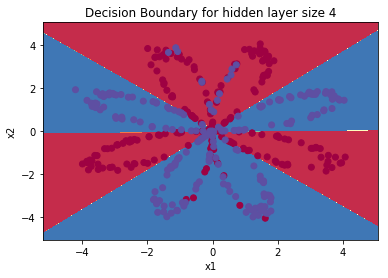

In [28]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)


# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [29]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


### 4.6 - 调整隐藏层大小 ###

Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.75 %


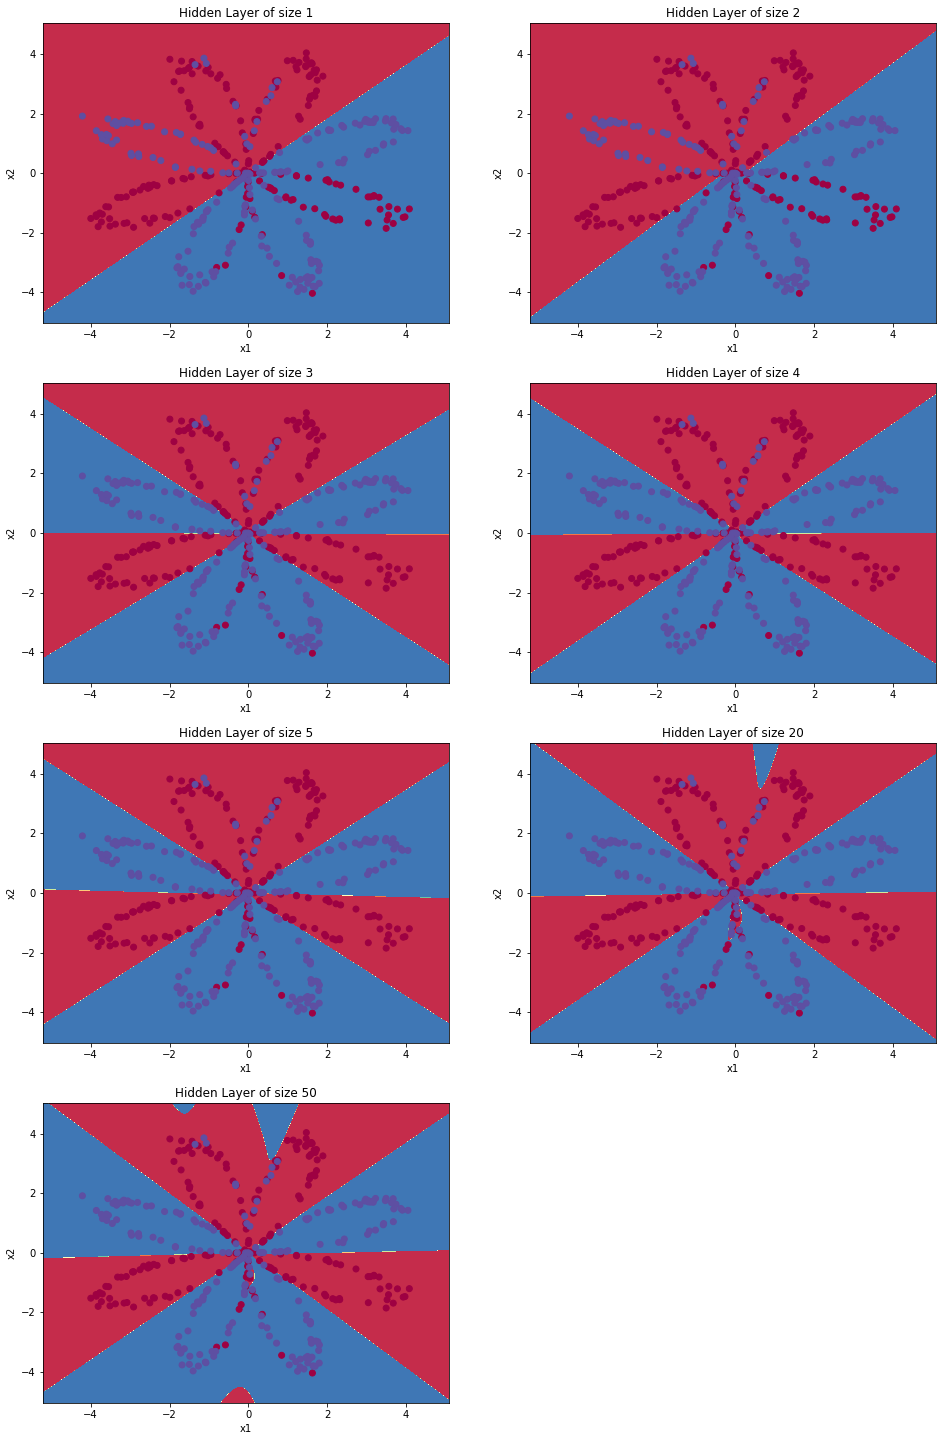

In [30]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.
- You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

## 5) 其他数据性能

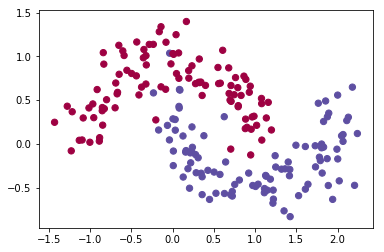

In [31]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Accuracy for 1 hidden units: 86.5 %
Accuracy for 2 hidden units: 87.0 %
Accuracy for 3 hidden units: 97.0 %
Accuracy for 4 hidden units: 98.5 %
Accuracy for 5 hidden units: 87.0 %
Accuracy for 20 hidden units: 98.5 %
Accuracy for 50 hidden units: 89.5 %


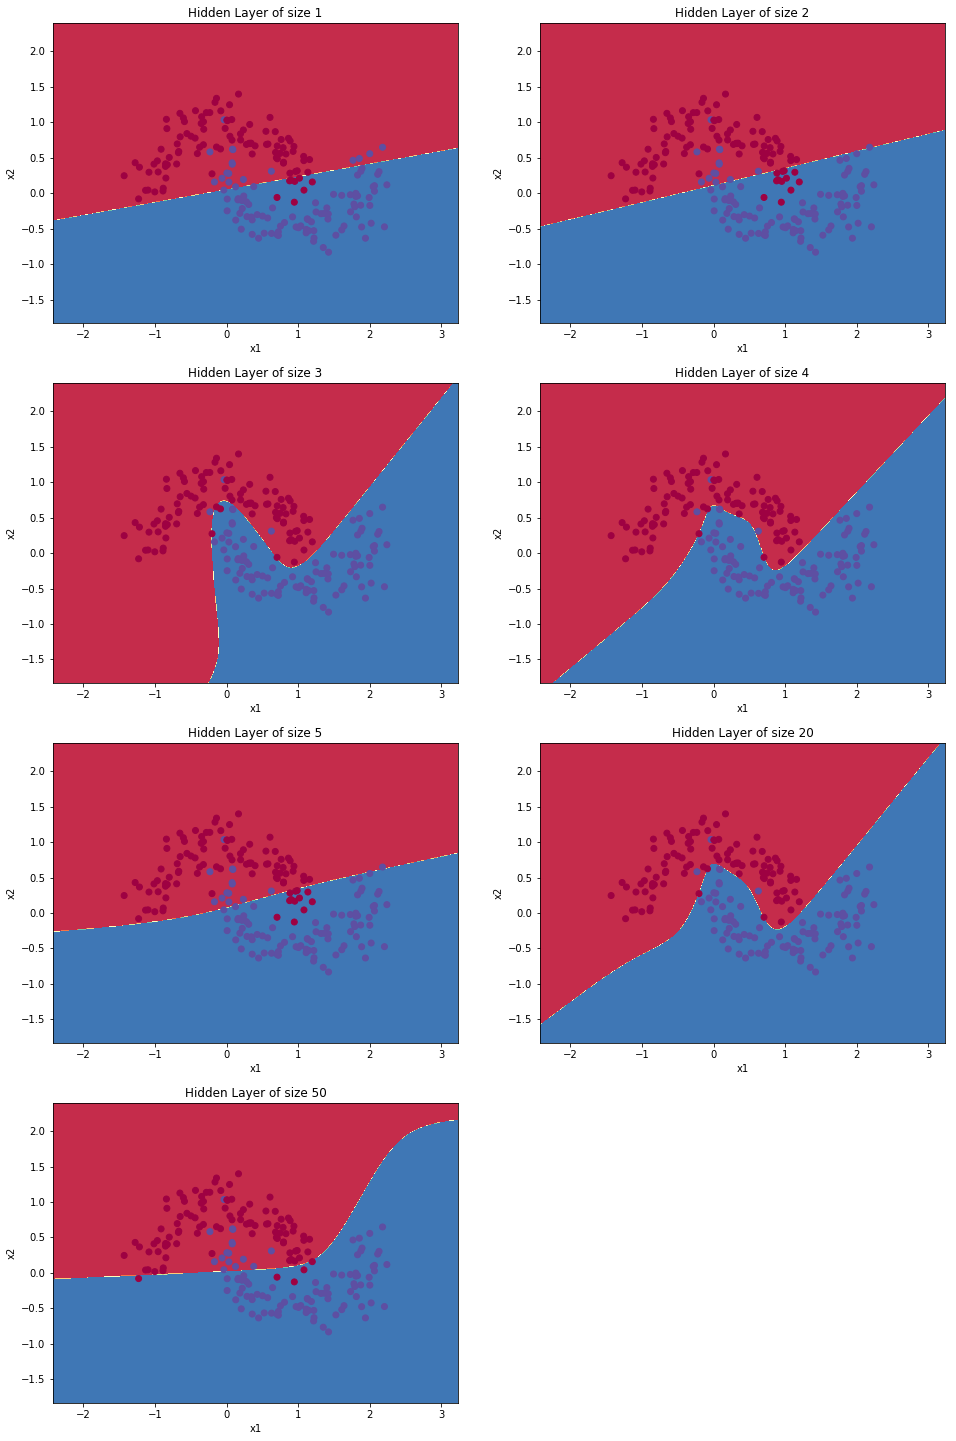

In [32]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))